In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold

In [9]:
from create_matrix import *

from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
year = 2014

import os


def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [10]:
n_splits = 10
import sys
case=2
a=2
cost='abs'

In [11]:
def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [12]:
from sklearn.model_selection import train_test_split, KFold

In [13]:
from common import compute_rmse_fraction
from common import compute_rmse

In [14]:
sd_df, sd_dfc = create_matrix_single_region("SanDiego", year)
sd_tensor = get_tensor(sd_df, sd_dfc)

In [23]:
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)

In [24]:
H_a, A_a, T_a = learn_HAT(case, au_tensor, a, a, num_iter=2000, lr=0.1, dis=False, cost_function=cost) 

### Normal learning

In [25]:
pred = {}
n_splits = 10
case = 2
a = 2
cost = 'abs'

for random_seed in range(10):
    pred[random_seed] = {}
    for appliance in APPLIANCES_ORDER:
        pred[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}

kf = KFold(n_splits=n_splits)
for random_seed in range(2):
    print "random seed: ", random_seed
    for train_percentage in range(10, 110, 10):
        print "training percentage: ", train_percentage
        rd = 0
        for train_max, test in kf.split(sd_df):
            print "round: ", rd
            rd += 1
            
            num_train = int((train_percentage*len(train_max)/100)+0.5)
            num_test = len(test)
            
            # get the random training data from train_max based on then random seed
            if train_percentage==100:
                train = train_max
            else:
                train, _ = train_test_split(train_max, train_size = train_percentage/100.0, random_state=random_seed)
            
            # get the index of training and testing data
            train_ix = sd_df.index[train]
            test_ix = sd_df.index[test]
            print "test_ix: ", test_ix
            
            # create the tensor
            train_test_ix = np.concatenate([test_ix, train_ix])
            df_t, dfc_t = sd_df.ix[train_test_ix], sd_dfc.ix[train_test_ix]
            tensor = get_tensor(df_t, dfc_t)
            tensor_copy = tensor.copy()
            # set the appliance consumption to be missing for testing data
            tensor_copy[:num_test, 1:, :] = np.NaN
            # do tensor factorization
            H, A, T = learn_HAT(case, tensor_copy, a, a, num_iter=2000, lr=0.1, dis=False, cost_function=cost)
            # get the prediction
            HAT = multiply_case(H, A, T, case)
            for appliance in APPLIANCES_ORDER:
                pred[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))



random seed:  0
training percentage:  10
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
training percentage:  20
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
te

In [26]:
out = {}
for random_seed in range(2):
    out[random_seed] = {}
       
    for appliance in APPLIANCES_ORDER[1:]:
        out[random_seed][appliance] = {}
        for f in range(10, 110, 10):
            s = pd.concat(pred[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]   

In [31]:
pd.DataFrame(out[1])

,dw,fridge,hvac,mw,oven,wm
10,1.889960,8.860580,24.664389,2.153953,2.406242,1.752266
20,2.224924,8.747860,15.167088,1.838831,2.132683,1.696060
30,2.210889,8.308375,16.214747,1.786446,2.095022,1.418868
40,2.336380,7.580287,15.861456,1.785369,2.066114,1.082316
50,2.211196,8.001783,21.478854,1.854116,2.153291,0.883630
60,1.946580,8.806745,42.097038,1.801054,2.101321,0.735274
70,1.955135,6.732251,17.728324,1.725218,2.154696,0.767595
80,1.951023,6.640553,17.487329,1.753869,2.064127,0.787147
90,1.894171,6.979950,16.693488,1.750205,2.119207,0.760351
100,1.882632,7.051506,16.226711,1.759001,2.076530,0.673275


### Transfer learning with A_au

In [30]:
from scipy.optimize import nnls

pred_transfer = {}
n_splits = 10
case = 2
a = 2
cost = 'abs'


for random_seed in range(10):
    pred_transfer[random_seed] = {}
    for appliance in APPLIANCES_ORDER:
        pred_transfer[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}

kf = KFold(n_splits=n_splits)
for random_seed in range(2):
    print "random seed: ", random_seed
    for adapt_percentage in range(10, 110, 10):
        print "adapt percentage: ", adapt_percentage
        rd = 0
        for adapt_max, test in kf.split(sd_df):
            print "round: ", rd
            rd += 1
            
            num_adapt = int((adapt_percentage*len(adapt_max)/100)+0.5)
            num_test = len(test)
            
            # get the random training data from train_max based on then random seed
            if adapt_percentage == 100:
                adapt = adapt_max
            else:
                adapt, _ = train_test_split(adapt_max, train_size = adapt_percentage/100.0, random_state=random_seed)
            
            # get the index of training and testing data
            adapt_ix = sd_df.index[adapt]
            test_ix = sd_df.index[test]
            print "test_ix: ", test_ix
            
            # create the tensor
            adapt_df = sd_df.ix[adapt_ix]
            test_df = sd_df.ix[test_ix]
            adapt_dfc = sd_dfc.ix[adapt_ix]
            test_dfc = sd_dfc.ix[test_ix]
            adapt_sd_tensor = get_tensor(adapt_df, adapt_dfc)
            
            # use the adpat data with A_au from Austion to learn T_sd_adapt
            H_sd_adapt, A_sd_adapt, T_sd_adapt = learn_HAT(case, adapt_sd_tensor, a, a, num_iter=2000, lr=0.1, dis=False, cost_function=cost, A_known=A_a)

            # Then we use T_sd_adapt, A_a and aggregate readings to learn H_sd in SanDiego
            test_sd_tensor = get_tensor(test_df, test_dfc)
            # Get the aggregate information of test homes
            aggregate_test = test_sd_tensor[:, 0, :]
            # Use A_au from Austin and T_sd_adapt learn previous
            AT_mat = np.einsum('ab, Ob -> aO', A_a[0], T_sd_adapt)
            
            # Estimate Home factor H_test_mat for test homes
            H_test_mat = np.zeros((len(test_df), 2))
            for j in range(len(test_df)):
                mask_rows = pd.Series(aggregate_test[j,:]).notnull()
                H_test_mat[j,:] = nnls(AT_mat.transpose()[mask_rows], aggregate_test[j,:][mask_rows])[0]
            pred_overall = np.einsum('Ma, Nab, Ob -> MNO', H_test_mat, A_a, T_sd_adapt)
            
            for appliance_name, appliance_id in appliance_index.iteritems():
                pred_transfer[random_seed][appliance_name][adapt_percentage].append(pd.DataFrame(pred_overall[:,appliance_id,:], index=test_df.index))
            

random seed:  0
adapt percentage:  10
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
adapt percentage:  20
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:

In [33]:
out_transfer = {}
for random_seed in range(2):
    out_transfer[random_seed] = {}
       
    for appliance in APPLIANCES_ORDER[1:]:
        out_transfer[random_seed][appliance] = {}
        for f in range(10,110,10):
            s = pd.concat(pred_transfer[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_transfer[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_transfer[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

    

In [34]:
pd.DataFrame(out_transfer[1])

,dw,fridge,hvac,mw,oven,wm
10,2.053068,11.706190,25.127803,2.411592,2.693010,0.976293
20,1.876049,11.133525,15.443178,2.304078,2.281569,0.945150
30,1.874221,11.358535,15.658179,2.293658,2.289494,0.949706
40,1.850130,11.139024,14.976882,2.276739,2.222553,0.935856
50,1.840099,10.821562,15.926967,2.279073,2.149089,0.927273
60,1.823591,10.337912,16.621659,2.262958,2.101876,0.904158
70,1.825326,10.625622,16.734060,2.267071,2.091832,0.916185
80,1.821489,10.460334,17.140002,2.262512,2.075196,0.906939
90,1.817427,10.367825,16.722409,2.259955,2.072612,0.901479
100,1.818491,10.322608,16.341788,2.261819,2.063225,0.903011


In [35]:
mean_out_normal = pd.Panel(out).mean(axis=0)

In [36]:
mean_out_transfer = pd.Panel(out_transfer).mean(axis=0)

In [37]:
# df_out_normal = pd.DataFrame(out_normal)]
mean_out_normal = mean_out_normal.rename(columns={'dw':'dw_normal', 'fridge':'fridge_normal', 'hvac':'hvac_normal',
                                             'mw':'mw_normal', 'oven':"oven_normal", 'wm':'wm_normal'})
mean_out_transfer = mean_out_transfer.rename(columns={'dw':'dw_transfer', 'fridge':'fridge_transfer', 'hvac':'hvac_transfer',
                                             'mw':'mw_transfer', 'oven':"oven_transfer", 'wm':'wm_transfer'})

all_out = pd.concat([mean_out_normal, mean_out_transfer], axis=1)


In [38]:
all_out

,dw_normal,fridge_normal,hvac_normal,mw_normal,oven_normal,wm_normal,dw_transfer,fridge_transfer,hvac_transfer,mw_transfer,oven_transfer,wm_transfer
10,2.210339,8.651920,22.252338,1.957959,2.374975,1.758963,1.969499,11.440342,22.241035,2.374004,2.504461,0.966345
20,2.157019,8.467825,16.794925,2.084567,2.521797,1.491809,1.875902,11.116321,15.748278,2.300087,2.264718,0.942895
30,2.056912,7.981841,17.727109,1.822477,2.142588,1.218666,1.872353,11.248970,15.874154,2.292101,2.264040,0.945260
40,2.108725,7.434858,16.458364,1.813764,2.069185,1.040632,1.852148,11.170182,15.986525,2.280001,2.217757,0.937476
50,2.049185,7.577498,19.252585,1.825054,2.120744,0.805846,1.840629,10.858977,16.282252,2.276587,2.150663,0.927230
60,1.910138,8.250822,30.300199,1.788900,2.070909,0.728190,1.822325,10.423863,16.299447,2.266511,2.090283,0.908471
70,1.920209,7.010219,18.020753,1.727362,2.126271,0.730257,1.822173,10.532826,16.512274,2.267901,2.082257,0.912644
80,1.919044,6.863812,17.346531,1.766003,2.057335,0.737063,1.820426,10.454502,17.014568,2.263839,2.075660,0.907735
90,1.893030,6.974902,16.673514,1.749955,2.124033,0.749586,1.818215,10.363373,16.590946,2.261338,2.068535,0.903082
100,1.882632,7.051506,16.226711,1.759001,2.076530,0.673275,1.818491,10.322608,16.341788,2.261819,2.063225,0.903011


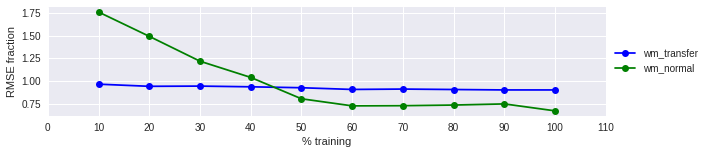

In [43]:
import seaborn

appliance = "wm"

df1 = all_out[appliance+ '_transfer']
df2 = all_out[appliance+ '_normal']
# df3 = all_out[appliance+ '_agg_1']
# df4 = all_out[appliance+ '_agg_2']
# df5 = all_out[appliance+ '_agg_3']
# df6 = all_out[appliance+ '_agg_4']
# df7 = all_out[appliance+ '_reg']
df = pd.concat([df1, df2], axis=1)
ax = pd.DataFrame(df).plot(figsize=(10, 2), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


major_ticks = np.arange(0, 101, 20)   

ax.set_xlabel("% training");
ax.locator_params(tight=False, nbins=20, axis='x')
ax.set_ylabel('RMSE fraction')

In [27]:
means_df = pd.Panel(out_transfer).mean(axis=0)
means_df

,dw,fridge,hvac,mw,oven,wm
10,1.940062,7.964142,20.152170,1.848286,2.246747,0.710265
20,1.834920,7.051655,15.092373,1.732928,2.064491,0.676309
30,1.825730,6.964802,14.955310,1.721569,2.027633,0.676783
40,1.818372,6.904778,15.035287,1.713831,2.008722,0.671988
50,1.827093,6.928866,15.776701,1.715210,1.991017,0.678369
60,1.816907,6.980137,15.775924,1.714902,1.992311,0.662649
70,1.814935,6.978966,15.910266,1.716225,1.987047,0.663715
80,1.814537,7.006932,16.366448,1.712479,1.996223,0.661337
90,1.813959,6.977071,15.809013,1.709988,1.996831,0.657076


In [33]:
std_df = pd.Panel(out).std(axis=0)
std_df

,dw,fridge,hvac,mw,oven,wm
70,0.049394,0.393106,0.413556,0.003032,0.040199,0.052804
